Grassberger, On the Critical Behavior of the General Epidemic Process and Dynamical Percolation<br>
<br>
Where:<br>
Susceptible = S<br>
Infected = I<br>
Recovered = R<br>
The process is markoffian and infects nearest neibors with rate sigma:

$ S(n)+I(m)\rightarrow\sigma\rightarrow I(n)+I(m)$<br>
where (n,m) are nearest neighbors, and recovery rate rho:<br>
$I(n)\rightarrow\rho\rightarrow R(n)$<br>
<br>
If rho is fixed and the length of an epidemic depends on the ratio $\sigma/\rho$ then there is some critical value $\sigma_c$ for which an epidemic may be infinite, $\sigma>\sigma_c$, with probability $0<P(\sigma)<1$, or impossible, $\sigma>\sigma_c$. $P(\sigma)$ is merely the probability that the original infected sight belongs to an infinite cluster.

The recovery time implies illness lengths are exponentially distributed with mean value $T=1/\rho$. Replacing this with a fixed value equal to T, then the chance of passing from an infected node to a susceptible node is:
$p=1-e^{-\sigma T}$

Population by county:
    https://data.ers.usda.gov/reports.aspx?ID=17827



In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stat
import networkx as nx
import random
import copy
import math

## First Attempt

In [2]:
# Parameters
tr  = 0.2 # Transmissisiblity: 0 to 1
tao = 14  # Mean days I->R: 0 to Inf
n   = 100 # Population: 1 to Inf
hh  = 30  # Households: 1 to n
er  = 10  # Employers: 0 to wf
sch = 5   # Quantity of school #[old version] Dictionary of schools and [grades served]
age_dist = {'pk':.1,'sch':.3,'w':.5,'r':.1} # Dictionary of age distribution



In [3]:
def create_pop_graph(n):
    G = nx.Graph()
    pop = []
    pop_dict = {}
    for i in range(n):
        pop.append(i)
        G.add_node(i)
        r = random.random()
        if r<age_dist['pk']:
            pop_dict[i]='pk'
        elif r<age_dist['sch']+age_dist['pk']:
            pop_dict[i]='sch'
        elif r<age_dist['w']+age_dist['sch']+age_dist['pk']:
            pop_dict[i]='w'
        else:
            pop_dict[i] = 'r'
    return(G,pop,pop_dict)

G_pop,list_pop,dict_pop = create_pop_graph(n)

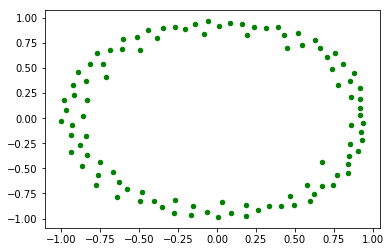

In [9]:
pos=nx.spring_layout(G_pop)

nx.draw_networkx_nodes(list(G_pop.edges()),pos,
                      nodelist=list_pop,
                      node_size = 20,
                      node_color='g')

In [10]:
def create_households(n,hh,G_pop,list_pop):
    G_hh = copy.deepcopy(G_pop)
    shuffled = copy.deepcopy(list_pop)
    random.shuffle(shuffled)
    hh_dict = {}
    hh_mean = n/hh
    trim = []
    for i in range(hh):
        v = stat.poisson.rvs(hh_mean)
        temp_list = []
        for j in range(v):
            if len(shuffled)>0:
                temp_list.append(shuffled.pop())
        hh_dict[i+n] = temp_list
    for i in range(len(shuffled)):
        hh_dict[random.randint(n,n+hh-1)].append(shuffled.pop())
    for k,v in hh_dict.items():
        if len(v) > 0:
            for i in v:
                G_hh.add_edge(i,k)
        else:
            trim.append(k)
    for i in trim:
        del hh_dict[i]
    return(G_hh,hh_dict)

G_hh,hh_dict = create_households(n,hh,G_pop,list_pop)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


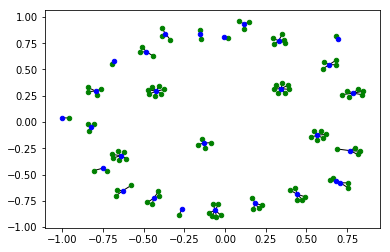

In [11]:
pos=nx.spring_layout(G_hh)

nx.draw_networkx_nodes(G_hh,pos,
                      nodelist=list_pop,
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_nodes(G_hh,pos,
                      nodelist=list(hh_dict.keys()),
                      node_size = 20,
                      node_color='b')

nx.draw_networkx_edges(G_hh,pos)

Given a location, is it appropriate to say the likelihood of having contact with another person there = C\*log(n)/n where n is the number of people present, where C is some constant?

In [12]:
def create_schools(G_hh,n,hh,dict_pop,age_dist,schools):
    G_sc = copy.deepcopy(G_hh)
    sc_dict = {}
    sch_list = []
    for i in range(schools):
        sc_dict[i+n+hh]=[]
        sch_list.append(i+n+hh)
    for k,v in dict_pop.items():
        if v=='sch':
            school_choice = random.choice(sch_list)
            G_sc.add_edge(k,school_choice)
            sc_dict[school_choice].append(k)
    return(G_sc,sc_dict)

G_sc,sc_dict = create_schools(G_hh,n,hh,dict_pop,age_dist,sch)
    

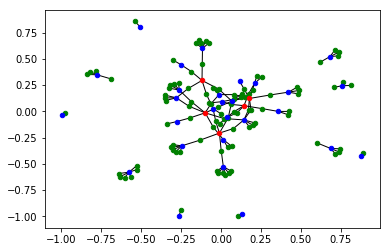

In [13]:
pos=nx.spring_layout(G_sc)

nx.draw_networkx_nodes(G_sc,pos,
                      nodelist=list_pop,
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_nodes(G_sc,pos,
                      nodelist=list(hh_dict.keys()),
                      node_size = 20,
                      node_color='b')

nx.draw_networkx_nodes(G_sc,pos,
                      nodelist=list(sc_dict.keys()),
                      node_size = 20,
                      node_color='r')

nx.draw_networkx_edges(G_sc,pos)



In [14]:
def create_workplaces(G_sc,dict_pop,er,n,hh,schools):
    G_w = copy.deepcopy(G_sc)
    prior = len(list(G_sc.nodes()))
    wo_dict = {}
    workforce = []
    trim = []
    for k,v in dict_pop.items():
        if v=='w':
            workforce.append(k)
    wo_mean = len(workforce)/er
    random.shuffle(workforce)
    for i in range(er):
        wo_dict[i+n+hh+schools] = []
        v = stat.poisson.rvs(wo_mean)
        for j in range(v):
            if len(workforce)>0:
                wo_dict[i+n+hh+schools].append(workforce.pop())
    while len(workforce)>0:
        wo_dict[random.choice(list(wo_dict.keys()))].append(workforce.pop())
    for k,v in wo_dict.items():
        if len(v)<1:
            trim.append(k)
    for i in trim:
        del wo_dict[i]
    for k,v in wo_dict.items():
        for i in v:
            G_w.add_edge(k,i)
    return(G_w,wo_dict)

G_w,wo_dict = create_workplaces(G_sc,dict_pop,er,n,hh,sch)

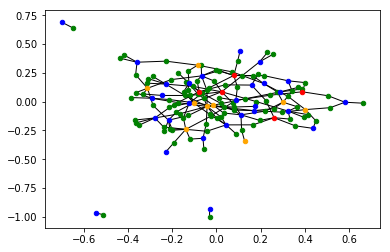

In [15]:
pos=nx.spring_layout(G_w)

nx.draw_networkx_nodes(G_w,pos,
                      nodelist=list_pop,
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_nodes(G_w,pos,
                      nodelist=list(hh_dict.keys()),
                      node_size = 20,
                      node_color='b')

nx.draw_networkx_nodes(G_w,pos,
                      nodelist=list(sc_dict.keys()),
                      node_size = 20,
                      node_color='r')

nx.draw_networkx_nodes(G_w,pos,
                      nodelist=list(wo_dict.keys()),
                      node_size = 20,
                      node_color='orange')

nx.draw_networkx_edges(G_w,pos)

## Second attempt
A second attempt at creating this system much more cleanly

In [447]:
# Parameters
tr  = 0.2 # Transmissisiblity: 0 to 1
tao = 14  # Mean days I->R: 0 to Inf
n   = 100 # Population: 1 to Inf
hh  = 30  # Households: 1 to n
er  = 10  # Employers: 0 to wf 
emp = 0.8 # Rate of employment
sch = 2   # Quantity of school #[old version] Dictionary of schools and [grades served]
age_dist = {'pk':.1,'sch':.3,'w':.95,'r':1} # Cumulative Dictionary of age distribution
age_list = sorted(list(age_dist.values()))
print(age_list)

[0.1, 0.3, 0.95, 1]


In [448]:
people_dict = {}

mean_home_size = n/hh
mean_work_size = age_dist['w'] * (n*emp) / er # accounts for employment rate
mean_school_size = age_dist['sch'] * n / sch

In [406]:
for i in range(n):
    people_dict[i] = {}
    r_age = random.random()
    for j in range(len(age_list)):
        if r_age <= age_list[j]:
            people_dict[i]['Age'] = j
            break

In [407]:
age_counts = {}
for k,v in people_dict.items():
    if v['Age'] in age_counts:
        age_counts[v['Age']] += 1
    else:
        age_counts[v['Age']]  = 1

In [408]:
def create_expected(start,end,mean,pop):
    counter = 0
    e_dict = {}
    for i in range(start,end):
        rand = stat.poisson.rvs(mean)
        if rand > 0:
            e_dict[i] = rand
            counter += rand
    nodes = list(e_dict.keys())
    while counter < pop:
        e_dict[random.choice(nodes)] += 1
        counter += 1
    while counter > pop:
        rand = random.choice(nodes)
        if e_dict[rand] > 1:
            e_dict[rand] -= 1
        else:
            del e_dict[rand]
            del nodes[nodes.index(rand)]
        counter -= 1
    return(e_dict)

In [409]:
home_dict   = create_expected(n,
                              hh+n,
                              mean_home_size,
                              n)

school_dict = create_expected(hh+n,
                              hh+n+sch,
                              mean_school_size,
                              age_counts[1])

work_dict   = create_expected(hh+n+sch,
                              hh+n+sch+er,
                              mean_work_size,
                              age_counts[2]*emp)
                            # Accounts for employment rates

In [410]:
homes, jobs, schools = [],[],[]

for k,v in home_dict.items():
    homes = homes + [k]*v
    
for k,v in school_dict.items():
    schools = schools + [k]*v

for k,v in work_dict.items():
    jobs = jobs + [k]*v

random.shuffle(homes)
random.shuffle(jobs)
random.shuffle(schools)

In [411]:
for k,v in people_dict.items():
    if v['Age'] == 1:
        v['School'] = schools.pop()
    else:
        v['School'] = -1
    if v['Age'] == 2:
        v['Work'] = jobs.pop()
    else:
        v['Work'] = -1
    v['Home'] = homes.pop()

In [449]:
G = nx.Graph()
for k,v in people_dict.items():
    for k2,v2 in v.items():
        if v2 > 0 and k2 != 'Age':
            G.add_edge(k,v2)

NetworkXError: Node 100 has no position.

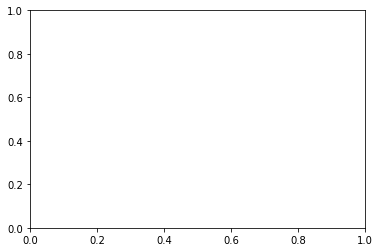

In [451]:
pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(people_dict.keys()),
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(home_dict.keys()),
                      node_size = 20,
                      node_color='b')

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(school_dict.keys()),
                      node_size = 20,
                      node_color='r')

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(work_dict.keys()),
                      node_size = 20,
                      node_color='orange')

nx.draw_networkx_edges(G,pos)

In [414]:
B = nx.Graph()
B.add_nodes_from(list(people_dict.keys()),bipartite=0)
B.add_nodes_from(list(home_dict.keys()),bipartite=1)
B.add_nodes_from(list(school_dict.keys()),bipartite=1)
B.add_nodes_from(list(work_dict.keys()),bipartite=1)

for k,v in people_dict.items():
    for k2,v2 in v.items():
        if v2 > 0 and k2 != 'Age':
            B.add_edge(k,v2)

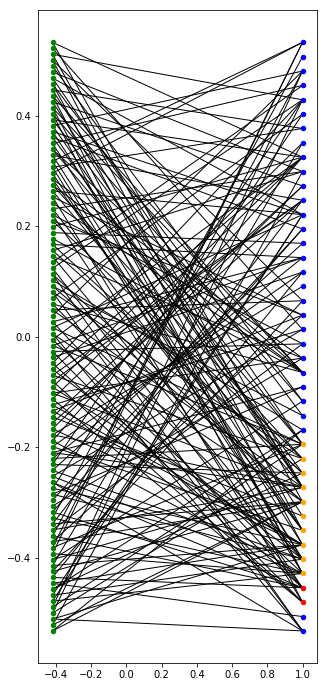

In [415]:
plt.figure(figsize=(5,12))

top = nx.bipartite.sets(B)[0]
pos = nx.bipartite_layout(B,top)

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(people_dict.keys()),
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(home_dict.keys()),
                      node_size = 20,
                      node_color='b')

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(school_dict.keys()),
                      node_size = 20,
                      node_color='r')

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(work_dict.keys()),
                      node_size = 20,
                      node_color='orange')

nx.draw_networkx_edges(B,pos)
plt.show()

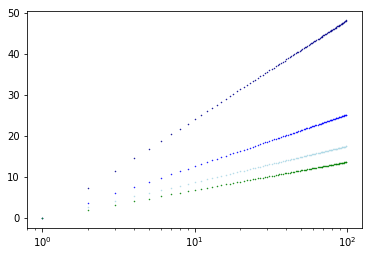

In [422]:
for i in range(1,100):
    plt.plot(i,math.log(i,1.1),'.',markersize=1,color='darkblue')
    plt.plot(i,math.log(i,1.2),'.',markersize=1,color='blue')
    plt.plot(i,math.log(i,1.3),'.',markersize=1,color='lightblue')
    plt.plot(i,math.log(i,1.4),'.',markersize=1,color='green')
plt.xscale('log')
plt.show()

In [417]:
math.log(16,1.2)
# Use min of log(x,1.2) and n at each location for exposure percentages based on logic. 

15.207136067695723

For schools and businesses, I will use log(x,1.2) for the number of contacts if the number of individuals is less than 15, and then a flat probability of contact among individuals within the school or business. This is an assumption and is not backed by any research at this time. 

For homes, the contact rate will be assumed to be 100%; there is no mechanism in this model for quarantining individuals within homes. 

The prior graph will be used to generate a single graph that will be used for percolation. Each node in the 'Individuals' category will be assigned links to other individuals that have links to the same 'Location' nodes. The number of contacts will be calculated as shown above. 

This is a time-based limitation; a better model would redraw at some random rate across locations to simulate different exposures over time. However, this model would be very time consuming to run. 

In [423]:
school_pop = {k: [] for k in list(school_dict.keys())}
work_pop = {k: [] for k in list(work_dict.keys())}
home_pop = {k: [] for k in list(home_dict.keys())}

for k,v in people_dict.items():
    if v['School'] >0:
        school_pop[v['School']].append(k)

for k,v in people_dict.items():
    if v['Work'] >0:
        work_pop[v['Work']].append(k)

for k,v in people_dict.items():
    if v['Home'] >0:
        home_pop[v['Home']].append(k)

In [424]:
for k,v in school_pop.items():
    print(k,v)

130 [39, 42, 47, 73, 87]
131 [9, 16, 20, 25, 45, 52, 61, 70]


In [438]:
G = nx.Graph()

school_edges = []
work_edges   = []

for k,v in home_pop.items():
    for i in range(len(v)-1):
        for j in range(len(v[i+1:])):
            G.add_edge(v[i],v[j])

for k,v in school_pop.items():
    if len(v) > 15:
        r = (math.log(len(v),1.2)//1)/len(v)
    else:
        r = 1
    for i in range(len(v)-1):
        for j in range(len(v[i+1:])):
            if random.random() < r:
                G.add_edge(v[i],v[j])
                school_edges.append([v[i],v[j]])

for k,v in work_pop.items():
    if len(v) > 15:
        r = (math.log(len(v),1.2)//1)/len(v)
    else:
        r = 1
    for i in range(len(v)-1):
        for j in range(len(v[i+1:])):
            if random.random() < r:
                G.add_edge(v[i],v[j])
                work_edges.append([v[i],v[j]])

for i in list(G.nodes()):
    #print(nx.clustering(G,i),list(G.neighbors(i)))
    if len(list(G.neighbors(i)))<1:   
        G.remove_node(i)

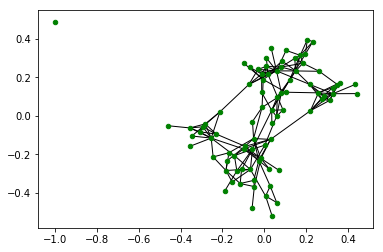

In [439]:
#nx.draw_networkx(G)

pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(G.nodes()),
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_edges(G,pos)

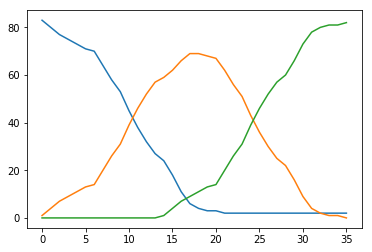

In [440]:
def percolate(G,tao,tr):
    # Set up data structures
    susceptible = list(G.nodes())
    infected = {}
    recovered = []
    patient0 = random.choice(susceptible)
    susceptible.remove(patient0)
    infected[patient0] = tao
    history = {'s':[len(susceptible)],'i':[1],'r':[0]}
    
    # Percolation Algorithm
    while len(infected) > 0:
        recover = []
        
        # Create new infections
        for i in list(infected.keys()):
            neighbors = list(G.neighbors(i))
            for j in neighbors :
                if j in susceptible:
                    if random.random()<tr:
                        susceptible.remove(j)
                        infected[j] = tao
            # Detect Recoveries
            infected[i] -=1
            if infected[i] <1:
                recover.append(i)
        
        # Clean up recoveries
        for i in recover:
            del infected[i]
            recovered.append(i)
        
        # Store current counts
        history['s'].append(len(susceptible))
        history['i'].append(len(infected))
        history['r'].append(len(recovered))
    
    return(history)

history = percolate(G,tao,tr)
plt.plot(history['s'])
plt.plot(history['i'])
plt.plot(history['r'])

[0.9880952380952381, 0.9523809523809523, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9761904761904762, 0.9642857142857143, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9761904761904762, 0.9642857142857143, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9761904761904762, 0.9761904761904762, 0.9761904761904762, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9761904761904762, 0.9880952380952381, 0.9880952380952381, 0.9761904761904762, 0.9880952380952381, 0.9761904761904762, 0.9761904761904762, 0.9880952380952381, 0.9761904761904762, 0.9880952380952381, 0.9880952380952381, 0.9761904761904762, 0.9880952380952381, 0.9761904761904762, 0.9880952380952381, 0.9880952380952381, 0.9880952380952381, 0.9761904761904762, 0.9880952380952381, 0.9761904761904762, 0.9761904761904762, 0.9761904761904762,

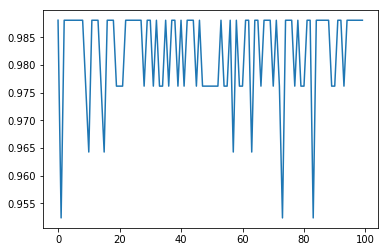

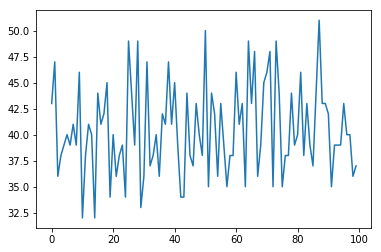

In [445]:
def mc_perc(G,tao,tr,n):
    Gp = copy.deepcopy(G)
    ratio_r_sr = []
    lengths = []
    for i in range(n):
        history = percolate(Gp,tao,tr)
        s = history['s'][-1]
        r = history['r'][-1]
        r_sr = r/(s+r)
        if r_sr > 0.02:
            ratio_r_sr.append(r/(s+r))
            lengths.append(len(history['s']))
    plt.plot(ratio_r_sr)
    plt.show()
    plt.plot(lengths)
    plt.show()

mc_perc(G,tao,tr,100)